In [130]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


def generate_data(a, b, Nθ, N, f, svd_trunc=0.999, N_trunc = -1):
    
    xx = np.linspace(0, 2*np.pi, N)
    θθ = np.linspace(a, b, Nθ)
    data = np.zeros((Nθ, N))
    for i in range(Nθ):
        for j in range(N):
            data[i, j] = f(θθ[i], xx[j])
    
    # svd bases
    u, s, vh = np.linalg.svd(data)
    
    if N_trunc < 0:
        s_sum_tot = sum(s)
        s_sum = 0.0
        for i in range(Nθ):
            s_sum += s[i]
            if s_sum > svd_trunc*s_sum_tot:
                break
        N_trunc = i+1
    print("0.99 energy N_trunc = ", N_trunc)


    
    scale = np.average(s[:N_trunc])
    data_svd = u[:, 0:N_trunc] * s[:N_trunc]/scale
    bases = vh[0:N_trunc, :]*scale

        
    return θθ, xx, data, data_svd, bases    

def torch_data(θ, xx, data, data_svd, method):

    if method == 1:
        Nθ = len(θ)
        N = len(xx)
        input_train  = np.zeros((Nθ*N, 2), dtype=np.float32) # θ, x, y
        output_train = np.zeros(Nθ*N, dtype=np.float32)

        for i in range(Nθ):
            for j in range(N):   
                input_train[i*N+j, :] = θ[i], xx[j]
                output_train[i*N+j] = data[i, j]

        x_train = torch.from_numpy(input_train.astype(np.float32)) 
        y_train = torch.from_numpy(output_train.astype(np.float32)).unsqueeze(-1)
    else:

        x_train = torch.from_numpy(θ.astype(np.float32)).unsqueeze(-1) 
        y_train = torch.from_numpy(data_svd.astype(np.float32))
    
    return x_train, y_train

In [131]:
# A neural network with u_n， θ_c
# u_d = K(θ_c) u_n
# u_d(x) = \int K(x, y, θ_c) u_n(y) dy
class DirectKernelNet(nn.Module):

    def __init__(self, Nθ, Ny):
        super(DirectKernelNet, self).__init__()
        self.Nθ = Nθ
        self.Ny = Ny
        # an affine operation: y = Wx + b
        
        self.fc1 = nn.Linear(Nθ, 20)
        self.fc2 = nn.Linear(20, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 20)
        self.fc5 = nn.Linear(20, Ny)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


# preprocess the training data 

class DirectData(Dataset):

    def __init__(self, X, y):
        
        self.X = X if torch.is_tensor(X) else torch.from_numpy(X)
        self.y = y if torch.is_tensor(y) else torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]




In [132]:
a, b = 0.0, 10.0
Nθ, N = 100, 100
f_name = "cos-thetax"
def f(θ, x):
    return np.cos(θ * x)

θ, xx, data, data_svd, bases = generate_data(a, b, Nθ, N, f)
θ_test, xx_test, data_test, data_svd_test, _ = generate_data(a, b, 2*Nθ, N, f)


0.99 energy N_trunc =  23
0.99 energy N_trunc =  23


# Train $(x, \theta) \to f(x, \theta)$

In [134]:
x_train, y_train = torch_data(θ, xx, data, data_svd, 1)


# training with adam
model = DirectKernelNet(2, 1)
loss_fn = torch.nn.MSELoss(reduction='sum')


#ADAM
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
n_epochs = 200000
for epoch in range(n_epochs):
    
        
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
        
    if epoch % 10000 == 0:
        print("[{}/{}], loss: {}".format(epoch, n_epochs, np.round(loss.item(), 3)))
        torch.save(model, "DirectKernelNet-"+f_name+"-1.model")
        


# #LBFGS        
# learning_rate = 1e-3
# optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate , max_iter=1000, line_search_fn='strong_wolfe')
# for epoch in range(200):
#     def closure():
#         optimizer.zero_grad()

#         y_pred = model(x_train)

#         # Compute and print loss.
#         loss = loss_fn(y_pred, y_train)
        
#         print(epoch, loss.item())
        
#         loss.backward()
#         return loss
#     optimizer.step(closure)


[0/200000], loss: 5511.879
[10000/200000], loss: 1504.206
[20000/200000], loss: 1458.548
[30000/200000], loss: 1437.335
[40000/200000], loss: 1414.882
[50000/200000], loss: 1394.163
[60000/200000], loss: 1385.654
[70000/200000], loss: 1360.52
[80000/200000], loss: 1385.327
[90000/200000], loss: 1340.085
[100000/200000], loss: 1331.693
[110000/200000], loss: 849.45
[120000/200000], loss: 764.487
[130000/200000], loss: 756.653
[140000/200000], loss: 754.112
[150000/200000], loss: 728.034
[160000/200000], loss: 673.983
[170000/200000], loss: 501.787
[180000/200000], loss: 405.746
[190000/200000], loss: 309.274


error is  0.2568989697499187


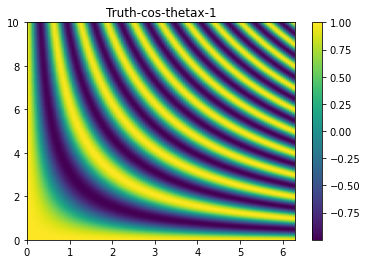

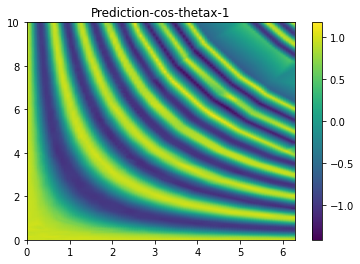

In [135]:
x_test, _ = torch_data(θ_test, xx_test, data_test, data_svd_test, 1)


Nθ, N = len(θ_test), len(xx_test)
y_pred = model(x_test).detach().numpy().reshape((Nθ, N))
y_test  = data_test

print("error is ", np.linalg.norm(y_test - y_pred)/np.linalg.norm(y_test))

θ_coord, x_coord = np.meshgrid(xx_test, θ_test)


vmin, vmax = np.min(y_test), np.max(y_test)
fig = plt.figure()
plt.pcolormesh(xx_test, θ_test, y_test, shading="gouraud")
plt.colorbar()
plt.title("Truth-"+f_name+"-1")
plt.savefig("Truth-"+f_name+"-1.png")

fig = plt.figure()
plt.pcolormesh(xx_test, θ_test, y_pred, shading="gouraud")
plt.colorbar()
plt.title("Prediction-"+f_name+"-1")
plt.savefig("Prediction-"+f_name+"-1.png")

# Train $(\theta) \to f(\cdot, \theta)$ With Reduced Basis


In [136]:
x_train, y_train = torch_data(θ, xx, data, data_svd, 2)

Ny = y_train.shape[1]
# training with adam
model = DirectKernelNet(1, Ny)
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

n_epochs = 500000
for epoch in range(n_epochs):
    
        
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
        
    if epoch % 10000 == 0:
        print("[{}/{}], loss: {}".format(epoch, n_epochs, np.round(loss.item(), 3)))
        torch.save(model, "DirectKernelNet-"+f_name+"-2.model")



[0/500000], loss: 85.394
[10000/500000], loss: 7.797
[20000/500000], loss: 5.278
[30000/500000], loss: 4.689
[40000/500000], loss: 3.328
[50000/500000], loss: 2.12
[60000/500000], loss: 2.025
[70000/500000], loss: 1.947
[80000/500000], loss: 1.924
[90000/500000], loss: 1.917
[100000/500000], loss: 1.91
[110000/500000], loss: 1.943
[120000/500000], loss: 1.876
[130000/500000], loss: 1.877
[140000/500000], loss: 0.846
[150000/500000], loss: 0.759
[160000/500000], loss: 0.753
[170000/500000], loss: 0.746
[180000/500000], loss: 0.186
[190000/500000], loss: 0.176
[200000/500000], loss: 0.195
[210000/500000], loss: 0.145
[220000/500000], loss: 0.143
[230000/500000], loss: 0.14
[240000/500000], loss: 0.144
[250000/500000], loss: 0.137
[260000/500000], loss: 0.166
[270000/500000], loss: 0.215
[280000/500000], loss: 0.137
[290000/500000], loss: 0.136
[300000/500000], loss: 0.139
[310000/500000], loss: 0.136
[320000/500000], loss: 0.13
[330000/500000], loss: 0.159
[340000/500000], loss: 0.127
[3

error is  0.06934428651756423


Text(0.5, 1.0, 'Prediction-cos-thetax-2.png')

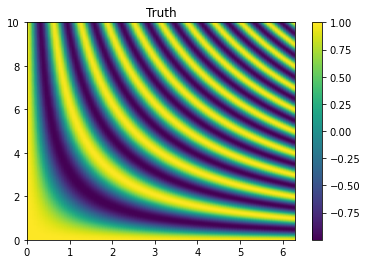

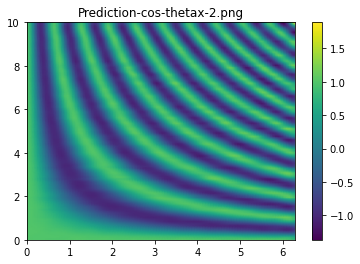

In [137]:
x_test, _ = torch_data(θ_test, xx_test, data_test, data_svd_test, 2)


Nθ, N = len(θ_test), len(xx_test)
y_pred = np.dot(model(x_test).detach().numpy(), bases).reshape((Nθ, N))
y_test = data_test

print("error is ", np.linalg.norm(y_test - y_pred)/np.linalg.norm(y_test))
θ_coord, x_coord = np.meshgrid(xx_test, θ_test)


vmin, vmax = np.min(y_test), np.max(y_test)
fig = plt.figure()
plt.pcolormesh(xx_test, θ_test, y_test, shading="gouraud")
plt.colorbar()
plt.title("Truth")
plt.savefig("Truth-"+f_name+"-2.png")
fig = plt.figure()
plt.pcolormesh(xx_test, θ_test, y_pred, shading="gouraud")
plt.colorbar()
plt.title("Prediction-"+f_name+"-2.png")